# Orthogonal SGPR Demo Notebook :)

This notebook is a sandbox for running experiments and playing around with orthogonal SGPR. Apologies if it's a little messy!

### Imports and Dependencies

In [1]:
import sys
import warnings
from copy import deepcopy
sys.path.insert(0, "..")
warnings.filterwarnings("ignore")

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from osvgp.datasets import load_snelson, generate_multi_sine
from osvgp.divergences import gaussian_kl
from osvgp.kernels import SquaredExponential
from osvgp.metrics import compute_lpd, compute_rmse
from osvgp.metrics import compute_kl_from_exact_posterior
from osvgp.models import GPR, SGPR, OSGPR
from osvgp.optimisers import LBFGS
from osvgp.plotting import plot_dataset, plot_predictions, overlay_predictions
from osvgp.plotting import plot_metrics_2d, plot_metrics_3d
from osvgp.processing import train_test_split
from osvgp.util import set_trainable

Fix the random seeds for repeatable results.

In [2]:
tf.random.set_seed(69)
rng = np.random.RandomState(69)

### Load Snelson Dataset

Most of the experiments we will conduct will be on the Snelson dataset, as it is a nice simple test case for which the exact solution is computable for comparison.

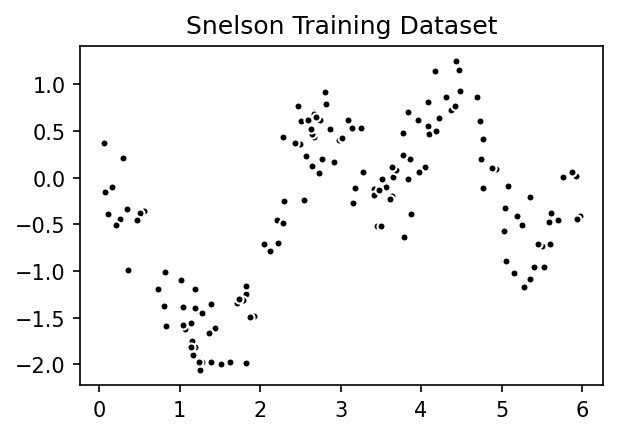

In [3]:
# Load Snelson dataset
data = load_snelson()
train_data, test_data = train_test_split(data, test_size=0.25)
X_train, y_train = train_data

# Plot dataset
plot_dataset(train_data, title="Snelson Training Dataset", figsize=(4.5, 3))

### Plot Predictions for Different Models

Let's plot some predictions for different models!

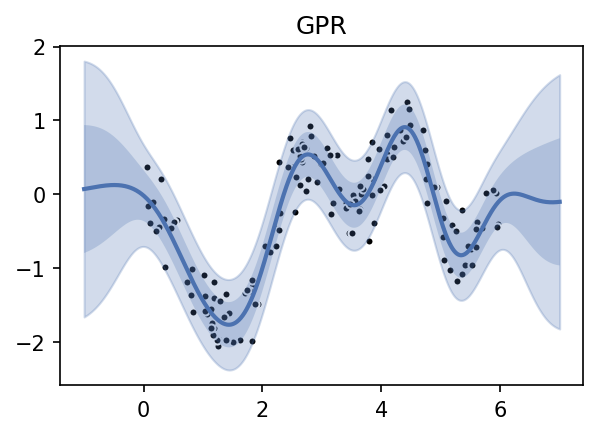

In [19]:
kernel = SquaredExponential()
gpr = GPR(train_data, kernel)
optimiser = LBFGS()
optimiser.minimise(gpr.training_loss, gpr.trainable_variables)
Xnew = np.linspace(-1.0, 7.0, 1000).reshape(-1, 1)
gpr_mean, gpr_var = gpr.predict_y(Xnew)
gpr_preds = (Xnew, gpr_mean, gpr_var)
plot_predictions(train_data, gpr_preds, None, 
                 c="C0", title="GPR", figsize=(4.5, 3))

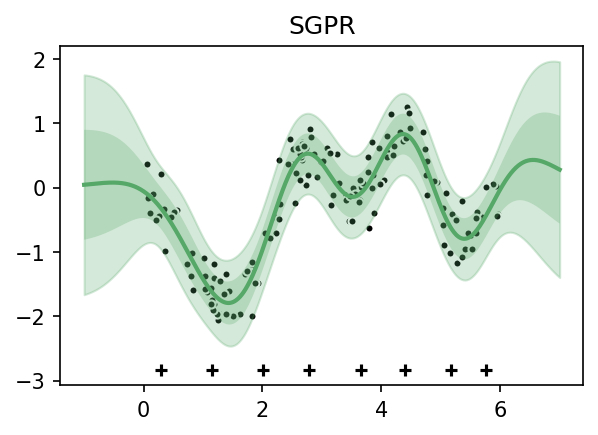

In [5]:
M = 8
kernel = SquaredExponential()
iv = X_train[:M].copy()
sgpr = SGPR(train_data, kernel, iv)
optimiser = LBFGS()
optimiser.minimise(sgpr.training_loss, sgpr.trainable_variables)
Xnew = np.linspace(-1.0, 7.0, 1000).reshape(-1, 1)
sgpr_mean, sgpr_var = sgpr.predict_y(Xnew)
sgpr_preds = (Xnew, sgpr_mean, sgpr_var)
sgpr_iv = sgpr.Z
plot_predictions(train_data, sgpr_preds, sgpr_iv, 
                 c="C1", title="SGPR", figsize=(4.5, 3))

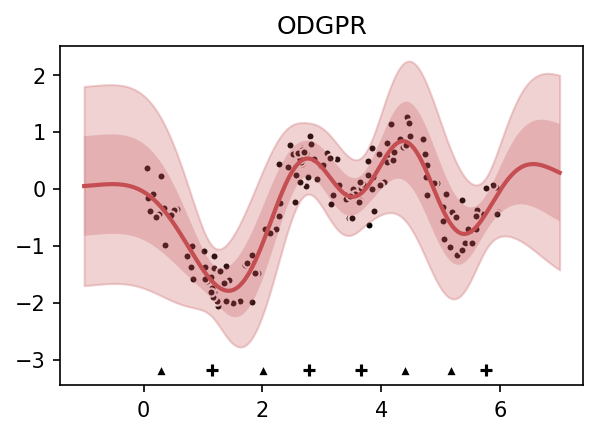

In [6]:
Mu, Mv = 4, 4
kernel = SquaredExponential()
iv = (X_train[:Mu].copy(), X_train[Mu:Mu+Mv].copy())
odgpr = OSGPR(train_data, kernel, iv, method="ODVGP")
optimiser = LBFGS()
optimiser.minimise(odgpr.training_loss, odgpr.trainable_variables)
Xnew = np.linspace(-1.0, 7.0, 1000).reshape(-1, 1)
odgpr_mean, odgpr_var = odgpr.predict_y(Xnew)
odgpr_preds = (Xnew, odgpr_mean, odgpr_var)
odgpr_iv = (odgpr.Z, odgpr.O)
plot_predictions(train_data, odgpr_preds, odgpr_iv, 
                 c="C2", title="ODGPR", figsize=(4.5, 3))

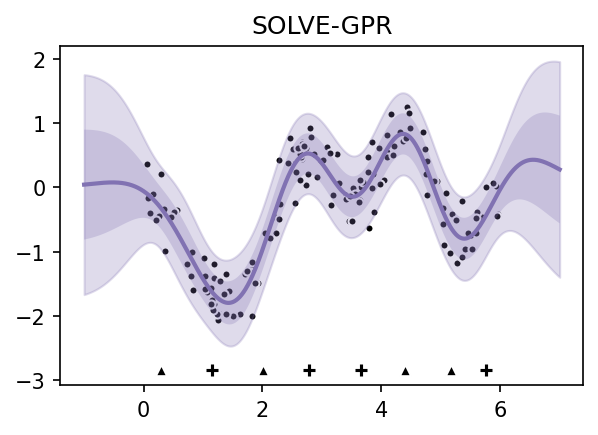

In [7]:
Mu, Mv = 4, 4
kernel = SquaredExponential()
iv = (X_train[:Mu].copy(), X_train[Mu:Mu+Mv].copy())
solvegpr = OSGPR(train_data, kernel, iv, method="SOLVE-GP")
optimiser = LBFGS()
optimiser.minimise(solvegpr.training_loss, solvegpr.trainable_variables)
Xnew = np.linspace(-1.0, 7.0, 1000).reshape(-1, 1)
solvegpr_mean, solvegpr_var = solvegpr.predict_y(Xnew)
solvegpr_preds = (Xnew, solvegpr_mean, solvegpr_var)
solvegpr_iv = (solvegpr.Z, solvegpr.O)
plot_predictions(train_data, solvegpr_preds, solvegpr_iv, 
                 c="C3", title="SOLVE-GPR", figsize=(4.5, 3))

### Plot Posterior Constituent Subprocesses

Let us plot the posterior constituent subprocesses for SOLVE-GPR.

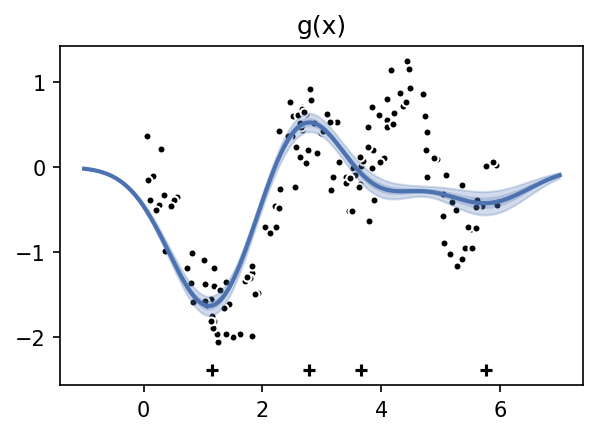

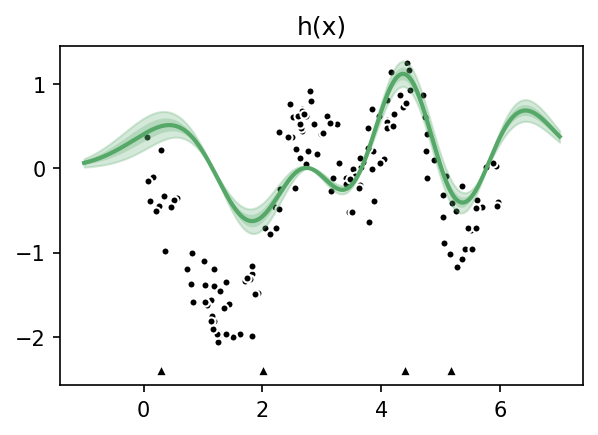

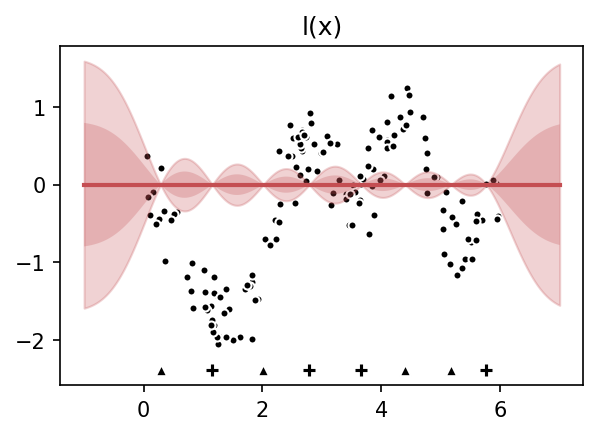

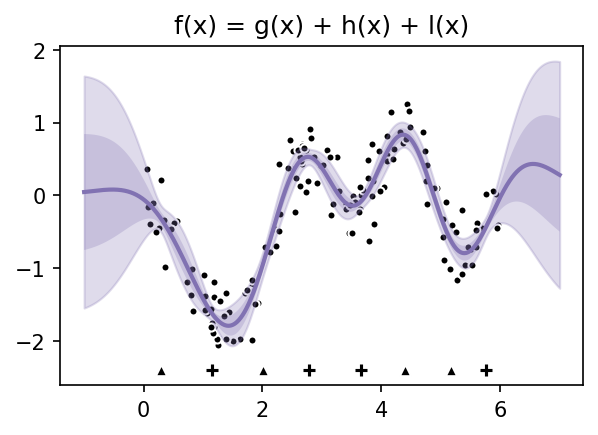

In [8]:
Mu, Mv = 4, 4
kernel = SquaredExponential()
iv = (X_train[:Mu].copy(), X_train[Mu:Mu+Mv].copy())
model = OSGPR(train_data, kernel, iv, method="SOLVE-GP")
optimiser = LBFGS()
optimiser.minimise(model.training_loss, model.trainable_variables)
Xnew = np.linspace(-1.0, 7.0, 1000).reshape(-1, 1)
f_mean, f_var = model.predict_f(Xnew)
f_preds = (Xnew, f_mean, f_var)
g_mean, g_var = model.predict_g(Xnew)
g_preds = (Xnew, g_mean, g_var)
h_mean, h_var = model.predict_h(Xnew)
h_preds = (Xnew, h_mean, h_var)
l_mean, l_var = model.predict_l(Xnew)
l_preds = (Xnew, l_mean, l_var)
plot_predictions(train_data, g_preds, (model.Z, None), 
                 c="C0", title="g(x)", figsize=(4.5, 3))
plot_predictions(train_data, h_preds, (None, model.O), 
                 c="C1", title="h(x)", figsize=(4.5, 3))
plot_predictions(train_data, l_preds, (model.Z, model.O), 
                 c="C2", title="l(x)", figsize=(4.5, 3))
plot_predictions(train_data, f_preds, (model.Z, model.O), 
                 c="C3", title="f(x) = g(x) + h(x) + l(x)", figsize=(4.5, 3))

### Compare Residual Covariance Subprocesses

Compare l(x) / h(x) subprocesses for SGPR and SOLVE-GPR.

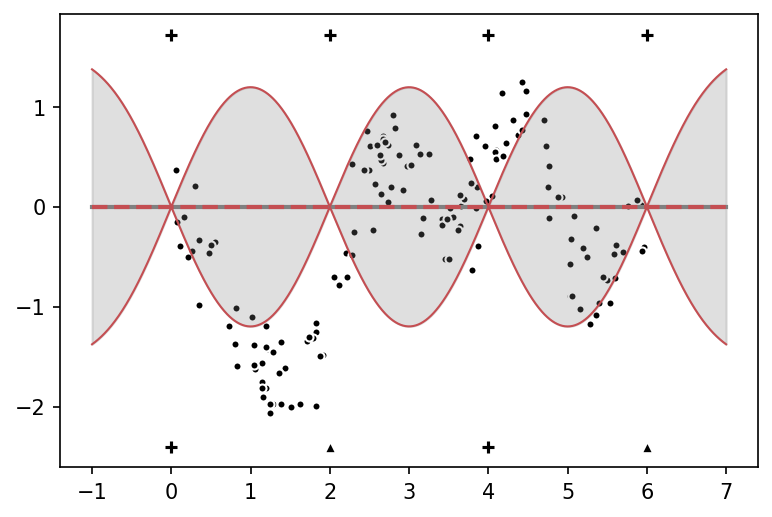

In [10]:
M = 4
noise_variance = 0.1
kernel = SquaredExponential(variance=0.6, lengthscales=0.8)

iv = np.linspace(0, 6, M).reshape(-1, 1)
# iv = np.array([0, 1, 3.25, 3.50, 3.75, 5, 6]).reshape(-1, 1)
# iv_orthog = (np.array([0, 1, 5, 6]).reshape(-1, 1), np.array([3.25, 3.50, 3.75]).reshape(-1, 1))
iv_orthog = (iv[::2], iv[1::2])
# iv_orthog = (iv[:M//2], iv[M//2:])
sgpr = SGPR(train_data, kernel, iv, noise_variance)
solvegpr = OSGPR(train_data, kernel, iv_orthog, noise_variance)

Xnew = np.linspace(-1.0, 7.0, 1000).reshape(-1, 1)
sgpr_h = sgpr.predict_h(Xnew)
sgpr_preds = (Xnew, *sgpr_h)
solvegpr_l = solvegpr.predict_l(Xnew)
solvegpr_preds = (Xnew, *solvegpr_l)
overlay_predictions(train_data, sgpr_preds, solvegpr_preds, iv, iv_orthog, figsize=(6, 4))

### Compute Metrics vs. Total Inducing Points (Various Splits)

Compute KL divergence from the true posterior, LPD, RMSE and ELBO for various models with different inducing point allocations

In [22]:
M_range = range(4, 51, 4)

base_dict = {"SGPR": [],
            #  "ODGPR 100/0": [],
            #  "ODGPR 50/50": [],
            #  "ODGPR 0/100": [],
             "SOLVE-GPR 100/0": [],
             "SOLVE-GPR 75/25": [],
             "SOLVE-GPR 50/50": [],
             "SOLVE-GPR 25/75": [],
             "SOLVE-GPR 0/100": []}

lpds = deepcopy(base_dict)
rmses = deepcopy(base_dict)
kls = deepcopy(base_dict)
elbos = deepcopy(base_dict)

for M in M_range:

    # Initialise models
    kernel = SquaredExponential(variance=0.8, lengthscales=0.6)
    iv_reg = X_train[:M].copy()
    iv_100_0 = (X_train[:M].copy(), X_train[M:M].copy())
    iv_75_25 = (X_train[:3*M//4].copy(), X_train[3*M//4:M].copy())
    iv_50_50 = (X_train[:M//2].copy(), X_train[M//2:M].copy())
    iv_25_75 = (X_train[:M//4].copy(), X_train[M//4:M].copy())
    iv_0_100 = (X_train[:0].copy(), X_train[:M].copy())
    models = [
        SGPR(train_data, deepcopy(kernel), iv_reg, noise_variance=0.1),
        # OSGPR(train_data, deepcopy(kernel), iv_100_0, noise_variance=0.1, method="ODVGP"),
        # OSGPR(train_data, deepcopy(kernel), iv_50_50, noise_variance=0.1, method="ODVGP"),
        # OSGPR(train_data, deepcopy(kernel), iv_0_100, noise_variance=0.1, method="ODVGP"),
        OSGPR(train_data, deepcopy(kernel), iv_100_0, noise_variance=0.1, method="SOLVE-GP"),
        OSGPR(train_data, deepcopy(kernel), iv_75_25, noise_variance=0.1, method="SOLVE-GP"),
        OSGPR(train_data, deepcopy(kernel), iv_50_50, noise_variance=0.1, method="SOLVE-GP"),
        OSGPR(train_data, deepcopy(kernel), iv_25_75, noise_variance=0.1, method="SOLVE-GP"),
        OSGPR(train_data, deepcopy(kernel), iv_0_100, noise_variance=0.1, method="SOLVE-GP")
    ]

    # # Optimise models
    # for model in [svgp, odvgp, solvegp]:
    #     optimiser = LBFGS()
    #     optimiser.minimise(model.training_loss, model.trainable_variables)
    
    # Compute metrics
    for model, key in zip(models, base_dict.keys()):
        lpds[key].append(compute_lpd(model, test_data))
        rmses[key].append(compute_rmse(model, test_data))
        kls[key].append(compute_kl_from_exact_posterior(model))
        elbos[key].append(model.elbo().numpy())

In [247]:
# Add jitter to make curve for distinguishable
max_jitter = 1/20
for key in kls.keys():
    kls[key] = [i + (rng.rand() * 2 - 1) * max_jitter * i for i in kls[key]]

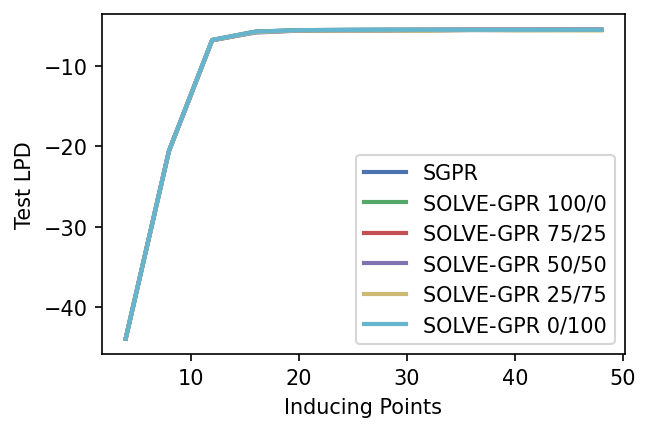

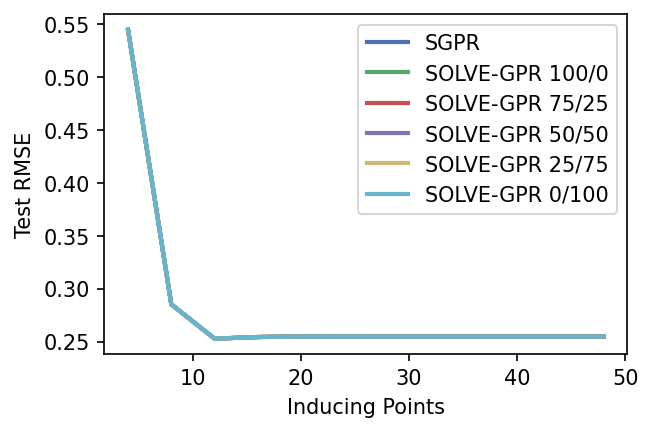

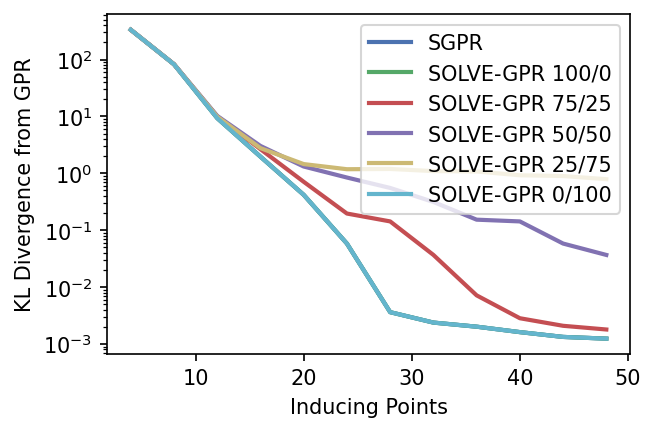

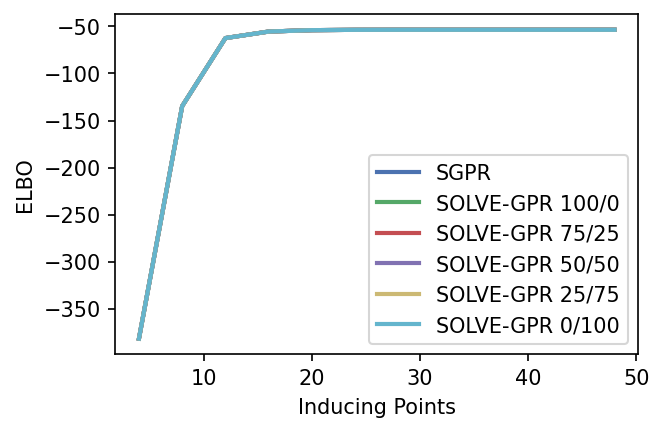

In [23]:
# LPD plot
plot_metrics_2d(M_range, 
                lpds,
                xlabel="Inducing Points",
                ylabel="Test LPD",
                yscale="linear",
                legend=True,
                figsize=(4.5, 3))

# RMSE plot
plot_metrics_2d(M_range, 
                rmses,
                xlabel="Inducing Points",
                ylabel="Test RMSE",
                yscale="linear",
                legend=True,
                figsize=(4.5, 3))

# KL divergence plot
plot_metrics_2d(M_range, 
                kls,
                xlabel="Inducing Points",
                ylabel="KL Divergence from GPR",
                yscale="log",
                legend=True,
                figsize=(4.5, 3))

# ELBO plot
plot_metrics_2d(M_range, 
                elbos,
                xlabel="Inducing Points",
                ylabel="ELBO",
                yscale="linear",
                legend=True,
                figsize=(4.5, 3))

### Compute KL Divergence vs. Inducing Point Allocation (3D)

Let us compute the KL divergence from the true posterior vs. inducing point allocation for SOLVE-GPR. The surface will look very different depending on how well we separate the inducing points. 

In [27]:
M_range = list(range(1, 26, 1))
kls = {"SOLVE-GP": np.zeros((len(M_range), len(M_range)))}
kernel = SquaredExponential(variance=0.8, lengthscales=0.6)
noise_var = 0.1

for i, M1 in enumerate(M_range):
    for j, M2 in enumerate(M_range):

        # Initialise model
        iv = (X_train[:M1].copy(), X_train[M1:M1+M2].copy())
        solvegpr = OSGPR(train_data, kernel, iv, noise_variance=noise_var)

        # Optimise model
        # optimiser = LBFGS()
        # optimiser.minimise(solvegpr.training_loss, solvegpr.trainable_variables)

        # Compute metrics
        kls["SOLVE-GP"][i][j] += compute_kl_from_exact_posterior(solvegpr)

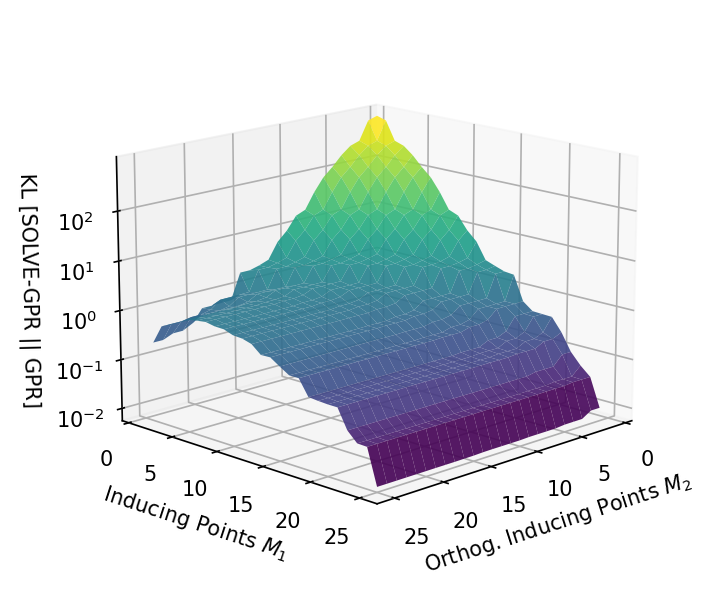

In [31]:
plot_metrics_3d(*np.meshgrid(M_range, M_range),
                kls["SOLVE-GP"],
                xlabel=r"Orthog. Inducing Points $M_2$",
                ylabel=r"Inducing Points $M_1$",
                zlabel="KL [SOLVE-GPR || GPR]",
                angle=(15, 45),
                figsize=(5, 5),
                zscale="log")

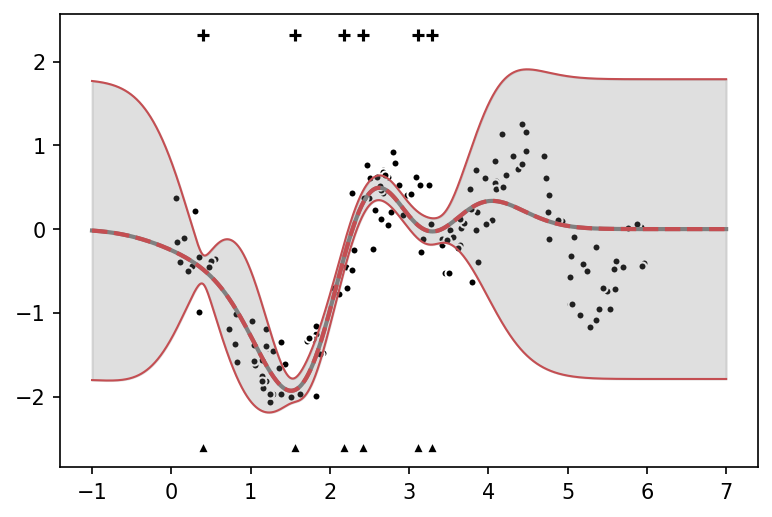

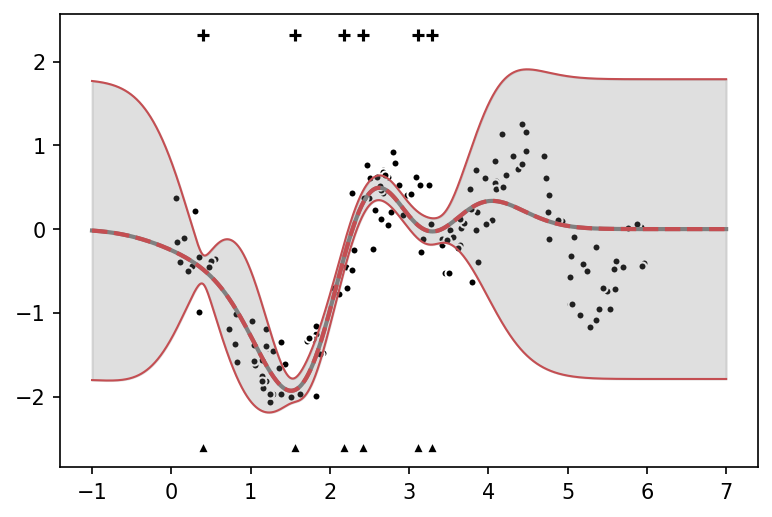

In [22]:
from osvgp.models import OSGPRBoundGap

M = 6
num_orthogonal = 6
kernel = SquaredExponential(variance=0.8, lengthscales=0.6)
noise_var = 0.1
# iv = np.linspace(0, 6, M).reshape(-1, 1)
iv = rng.rand(M).reshape(-1, 1) * 6

boundgap  = OSGPRBoundGap(train_data, kernel, iv, num_orthogonal, noise_var)
set_trainable(boundgap.kernel.variance, False)
set_trainable(boundgap.kernel.lengthscales, False)
set_trainable(boundgap.likelihood.variance, False)

Xnew = np.linspace(-1, 7, 10000).reshape(-1, 1)

sgpr_mean_var = boundgap.sgpr_predict_f(Xnew)
sgpr_preds = (Xnew, *sgpr_mean_var)
sgpr_iv = boundgap.SGPR_Z
solvegpr_mean_var = boundgap.osgpr_predict_f(Xnew)
solvegpr_preds = (Xnew, *solvegpr_mean_var)
solvegpr_iv = (boundgap.OSGPR_Z, boundgap.OSGPR_O)
overlay_predictions(train_data, sgpr_preds, solvegpr_preds, sgpr_iv, solvegpr_iv, figsize=(6, 4))

optimiser = LBFGS()
optimiser.minimise(boundgap.training_loss, boundgap.trainable_variables, 
                   options={"maxcor": 10000,
                            "ftol":1e-30,
                            "gtol": 1e-30,
                            "eps": 1e-30,
                            "maxfun": 150000,
                            "maxiter": 150000,
                            "maxls": 10000})

sgpr_mean_var = boundgap.sgpr_predict_f(Xnew)
sgpr_preds = (Xnew, *sgpr_mean_var)
sgpr_iv = boundgap.SGPR_Z
solvegpr_mean_var = boundgap.osgpr_predict_f(Xnew)
solvegpr_preds = (Xnew, *solvegpr_mean_var)
solvegpr_iv = (boundgap.OSGPR_Z, boundgap.OSGPR_O)
overlay_predictions(train_data, sgpr_preds, solvegpr_preds, sgpr_iv, solvegpr_iv, figsize=(6, 4))

In [23]:
print(boundgap.sgpr_elbo())
print(boundgap.osgpr_elbo())
print(boundgap.maximum_log_likelihood_objective())

tf.Tensor(-325.65211500714383, shape=(), dtype=float64)
tf.Tensor(-325.65211500714383, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)
